## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

/Users/juanitorduz/.local/share/virtualenvs/wolt-mmm-SmLb2E-L/lib/python3.8/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/.local/share/virtualenvs/wolt-mmm-SmLb2E-L/lib/python3.8/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Read Data

In [2]:
data_path = "https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv"

raw_data_df = pd.read_csv(data_path)

raw_data_df.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


## Data Formatting

In [3]:
data_df = raw_data_df.copy().assign(
    date=pd.date_range(
        start=pd.to_datetime("2011-01-01"), end=pd.to_datetime("2012-12-31"), freq="D"
    )
)

data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   season           731 non-null    object        
 1   yr               731 non-null    int64         
 2   mnth             731 non-null    object        
 3   holiday          731 non-null    object        
 4   weekday          731 non-null    object        
 5   workingday       731 non-null    object        
 6   weathersit       731 non-null    object        
 7   temp             731 non-null    float64       
 8   hum              731 non-null    float64       
 9   windspeed        731 non-null    float64       
 10  cnt              731 non-null    int64         
 11  days_since_2011  731 non-null    int64         
 12  date             731 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 74.4+ KB


In [10]:
target = "cnt"
endog_scaler = StandardScaler()
exog_scaler = StandardScaler()


data_df[f"{target}_scaled"] = endog_scaler.fit_transform(X=data_df[[target]])
data_df[["temp_scaled", "hum_scaled", "windspeed_scaled"]] = exog_scaler.fit_transform(
    X=data_df[["temp", "hum", "windspeed"]]
)


In [11]:
n = data_df.shape[0]

date = data_df["date"].to_numpy()

cnt_scaled = data_df[f"{target}_scaled"].to_numpy()

temp_scaled = data_df["temp_scaled"].to_numpy()
hum_scaled = data_df["hum_scaled"].to_numpy()
windspeed_scaled = data_df["windspeed_scaled"].to_numpy()
holiday_idx, holiday = data_df["holiday"].factorize(sort=True)
workingday_idx, workingday = data_df["workingday"].factorize(sort=True)
weathersit_idx, weathersit = data_df["weathersit"].factorize(sort=True)
t = data_df["days_since_2011"].to_numpy() / data_df["days_since_2011"].max()

n_order = 10
periods = data_df["date"].dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)


## Base Model

In [6]:
coords = {
    "date": date,
    "workingday": workingday,
    "weathersit": weathersit,
}


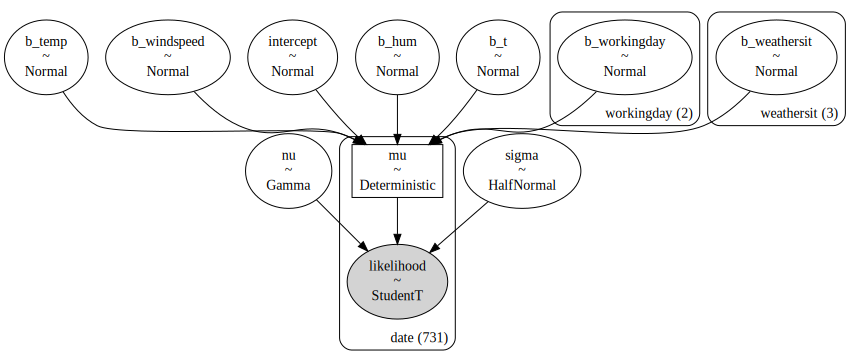

In [21]:
with pm.Model(coords=coords) as base_model:

    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_temp = pm.Normal(name="b_temp", mu=0, sigma=2)
    b_hum = pm.Normal(name="b_hum", mu=0, sigma=2)
    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=2)
    b_workingday = pm.Normal(name="b_workingday", mu=0, sigma=2, dims="workingday")
    b_weathersit = pm.Normal(name="b_weathersit", mu=0, sigma=2, dims="weathersit")
    b_t = pm.Normal(name="b_t", mu=0, sigma=3)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    # --- model parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=(
            intercept
            + b_t * t
            + b_temp * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )

    # --- prior samples ---
    prior_predictive_base = pm.sample_prior_predictive(samples=200)

pm.model_to_graphviz(base_model)


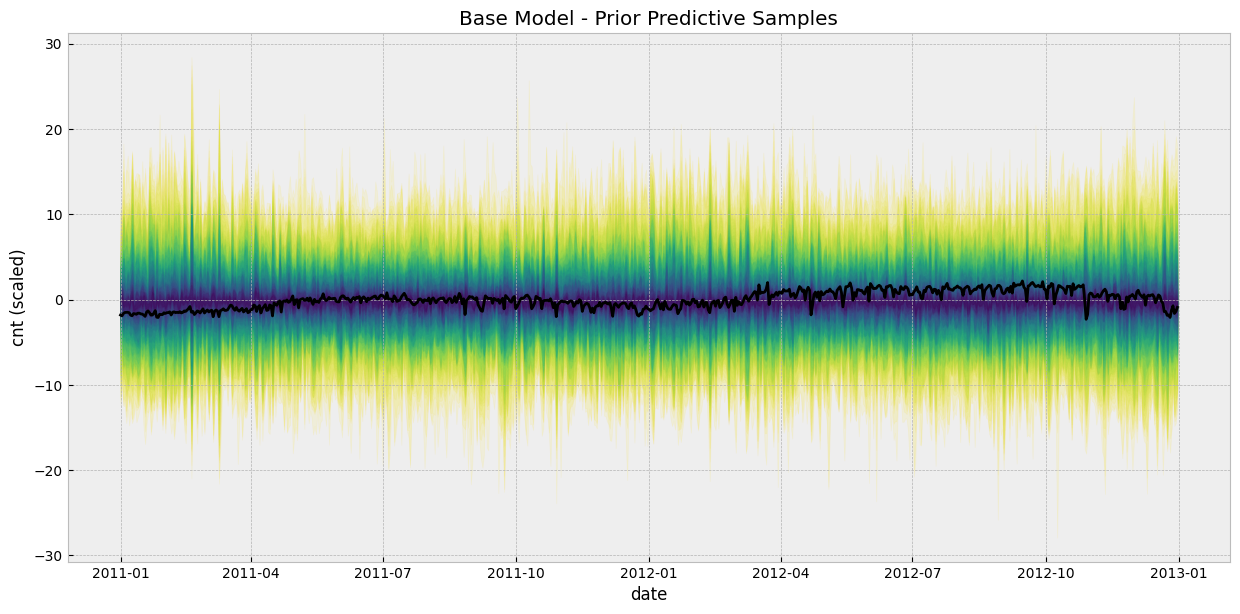

In [22]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        prior_predictive_base.prior_predictive["likelihood"], p, axis=1
    )
    lower = np.percentile(
        prior_predictive_base.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)
ax.set(
    title="Base Model - Prior Predictive Samples",
    xlabel="date",
    ylabel=f"{target} (scaled)",
);


In [14]:
with base_model:
    idata_base = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.8, draws=1000, chains=4
    )
    posterior_predictive_base = pm.sample_posterior_predictive(trace=idata_base)


Compiling...
Compilation time =  0:00:09.989991
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:29.042340
Transforming variables...
Transformation time =  0:00:00.690072
Computing Log Likelihood...
Log Likelihood time =  0:00:01.308287


In [15]:
az.summary(data=idata_base, var_names=["~mu"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.720,1.326,-3.007,1.986,0.029,0.021,2078.0,2195.0,1.0
b_temp,0.511,0.017,0.480,0.542,0.000,0.000,4068.0,2797.0,1.0
b_hum,-0.114,0.021,-0.152,-0.074,0.000,0.000,3493.0,2803.0,1.0
b_windspeed,-0.099,0.017,-0.131,-0.067,0.000,0.000,4008.0,2731.0,1.0
b_workingday[NO WORKING DAY],-0.376,1.185,-2.737,1.782,0.027,0.019,1975.0,2380.0,1.0
b_workingday[WORKING DAY],-0.309,1.185,-2.680,1.832,0.027,0.019,1974.0,2441.0,1.0
b_weathersit[GOOD],0.180,1.020,-1.770,1.993,0.025,0.017,1709.0,2143.0,1.0
b_weathersit[MISTY],-0.000,1.020,-1.774,1.994,0.025,0.017,1712.0,2106.0,1.0
b_weathersit[RAIN/SNOW/STORM],-0.760,1.021,-2.648,1.078,0.025,0.018,1725.0,2202.0,1.0
b_t,1.993,0.058,1.880,2.098,0.001,0.001,4297.0,2596.0,1.0


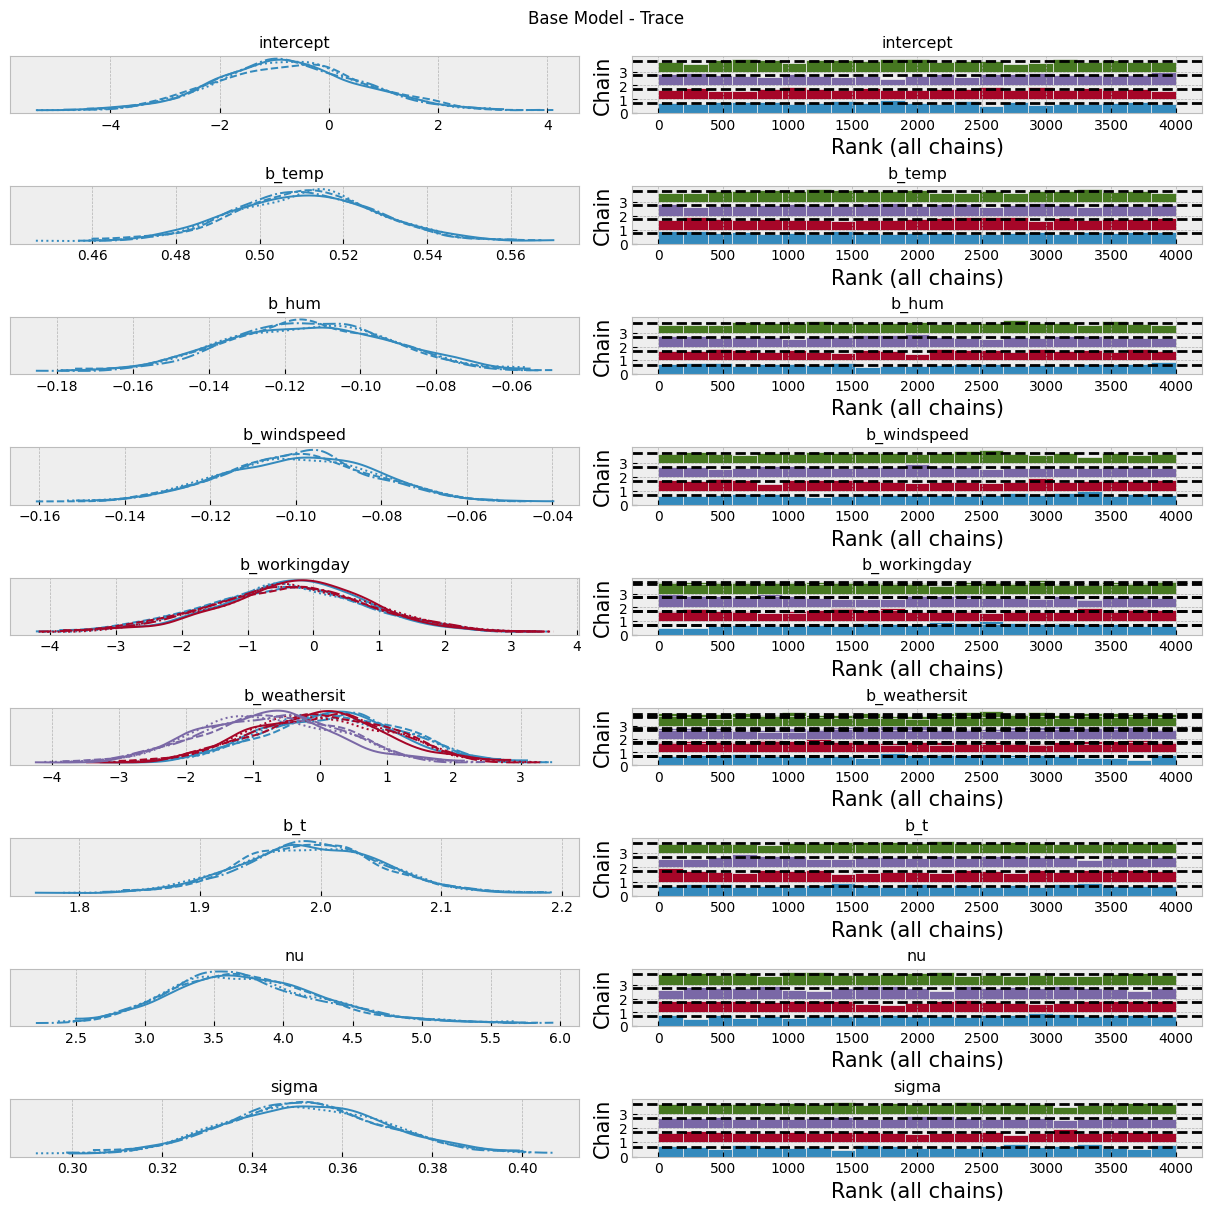

In [17]:
axes = az.plot_trace(
    data=idata_base,
    var_names=["~mu"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Base Model - Trace");


Text(0.5, 0.98, 'Base Model - Posterior Distributions')

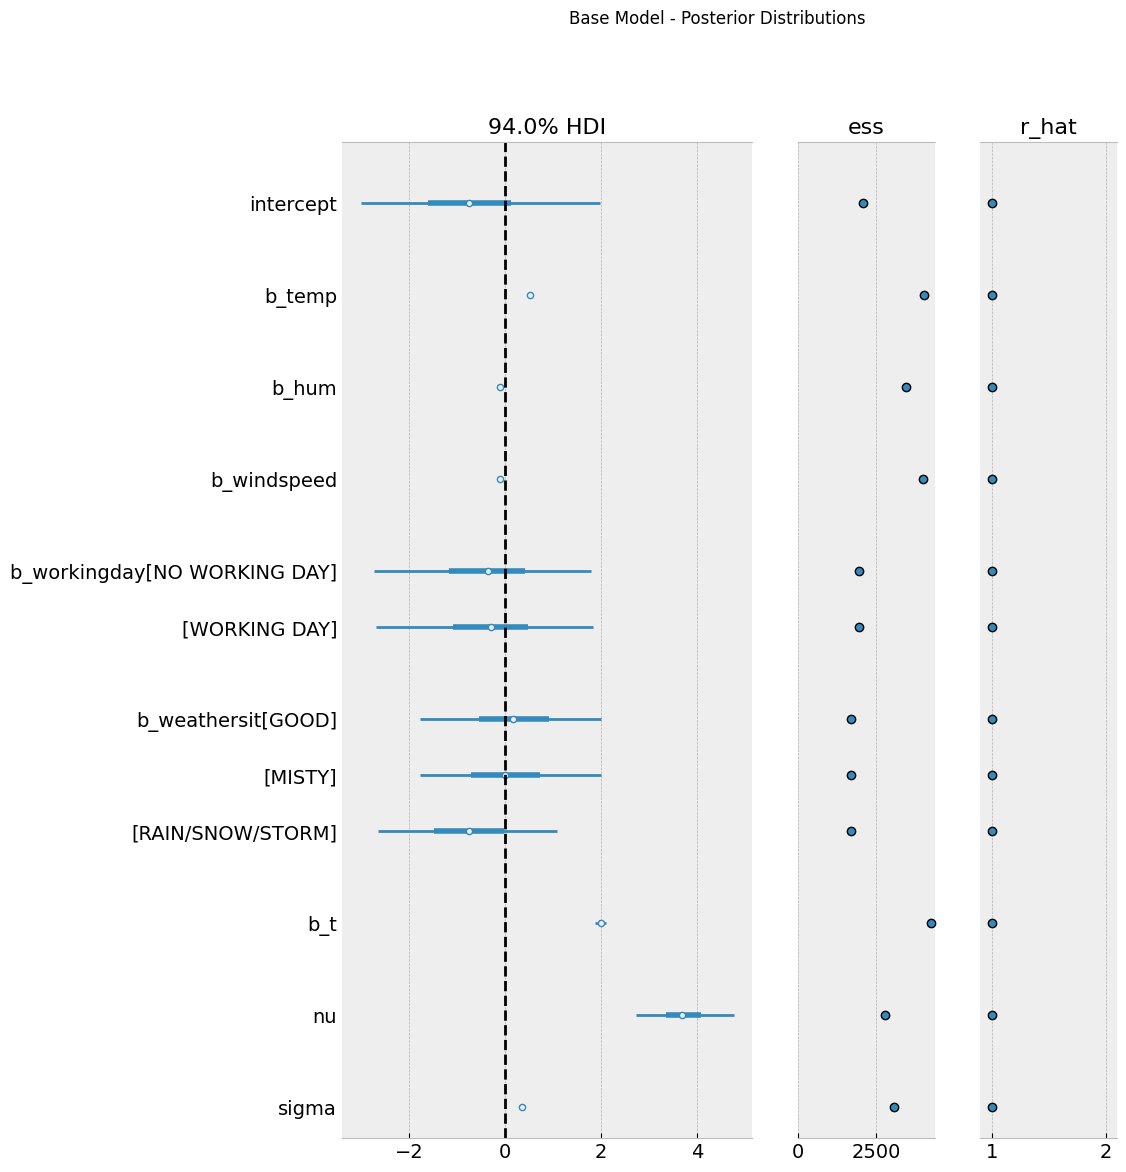

In [18]:
axes = az.plot_forest(
    data=idata_base,
    var_names=["~mu"],
    combined=True,
    r_hat=True,
    ess=True,
)
axes[0].axvline(x=0.0, color="black", linestyle="--")
plt.gcf().suptitle("Base Model - Posterior Distributions");


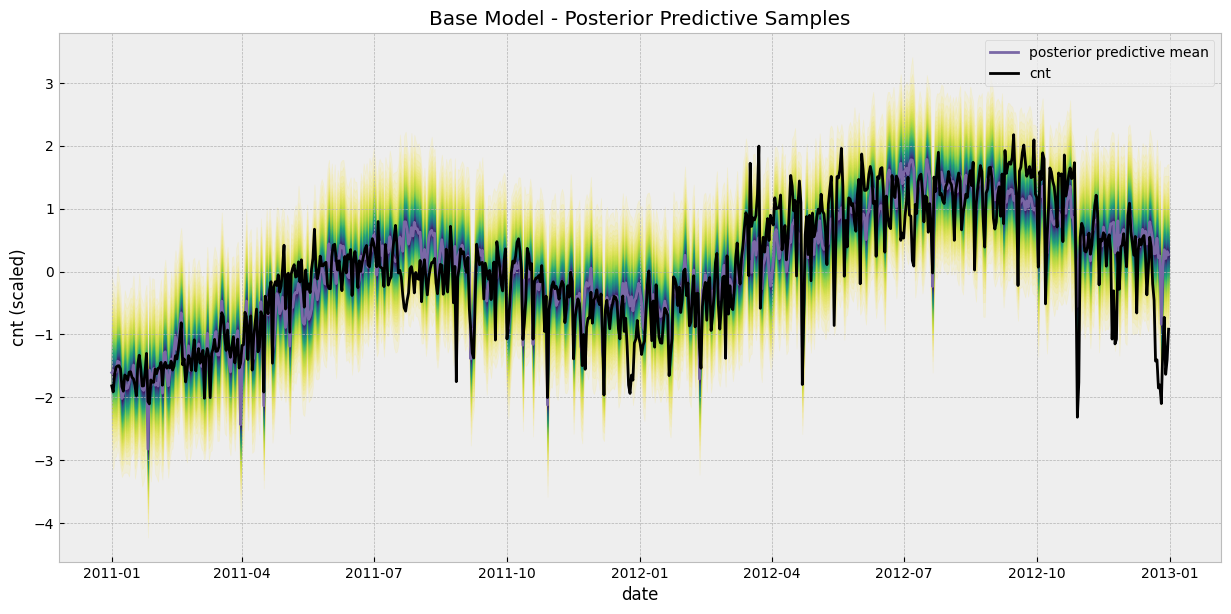

In [23]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood = posterior_predictive_base.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=cnt_scaled,
    color="black",
    label=target,
    ax=ax,
)

ax.set(
    title="Base Model - Posterior Predictive Samples",
    xlabel="date",
    ylabel=f"{target} (scaled)",
);


## Time-Varying Coefficients Model

/Users/juanitorduz/.local/share/virtualenvs/wolt-mmm-SmLb2E-L/lib/python3.8/site-packages/pymc/distributions/timeseries.py:274: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


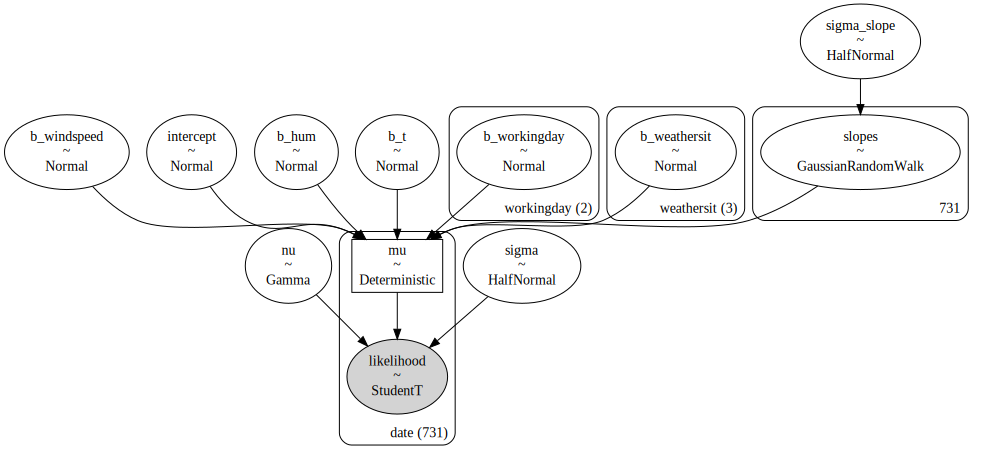

In [25]:
with pm.Model(coords=coords) as model:

    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_hum = pm.Normal(name="b_hum", mu=0, sigma=2)
    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=2)
    b_workingday = pm.Normal(name="b_workingday", mu=0, sigma=2, dims="workingday")
    b_weathersit = pm.Normal(name="b_weathersit", mu=0, sigma=2, dims="weathersit")
    b_t = pm.Normal(name="b_t", mu=0, sigma=3)
    sigma_slopes = pm.HalfNormal(name="sigma_slope", sigma=0.1)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    # --- model parametrization ---
    slopes = pm.GaussianRandomWalk(name="slopes", sigma=sigma_slopes, shape=date.size)
    mu = pm.Deterministic(
        name="mu",
        var=(
            intercept
            + b_t * t
            + slopes * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )

    # --- prior samples ---
    prior_predictive = pm.sample_prior_predictive(samples=200)

pm.model_to_graphviz(model)

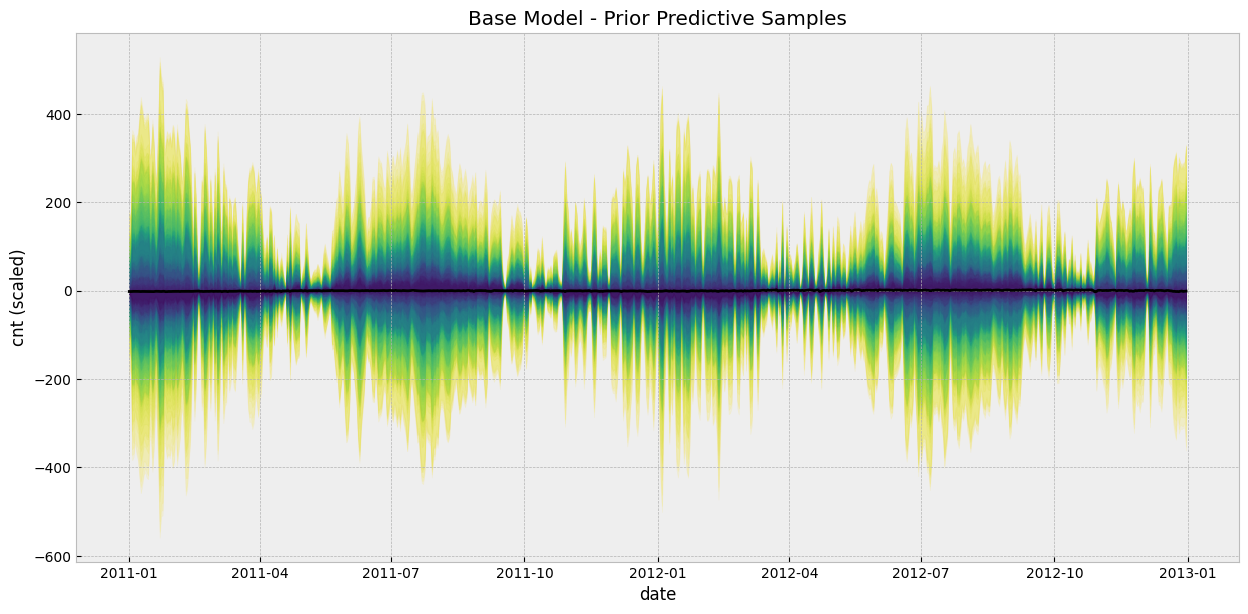

In [26]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        prior_predictive.prior_predictive["likelihood"], p, axis=1
    )
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)
ax.set(
    title="Base Model - Prior Predictive Samples",
    xlabel="date",
    ylabel=f"{target} (scaled)",
);


In [27]:
with base_model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.8, draws=1000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)


Compiling...
Compilation time =  0:00:02.742461
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:24.877420
Transforming variables...
Transformation time =  0:00:00.687727
Computing Log Likelihood...
Log Likelihood time =  0:00:00.689222


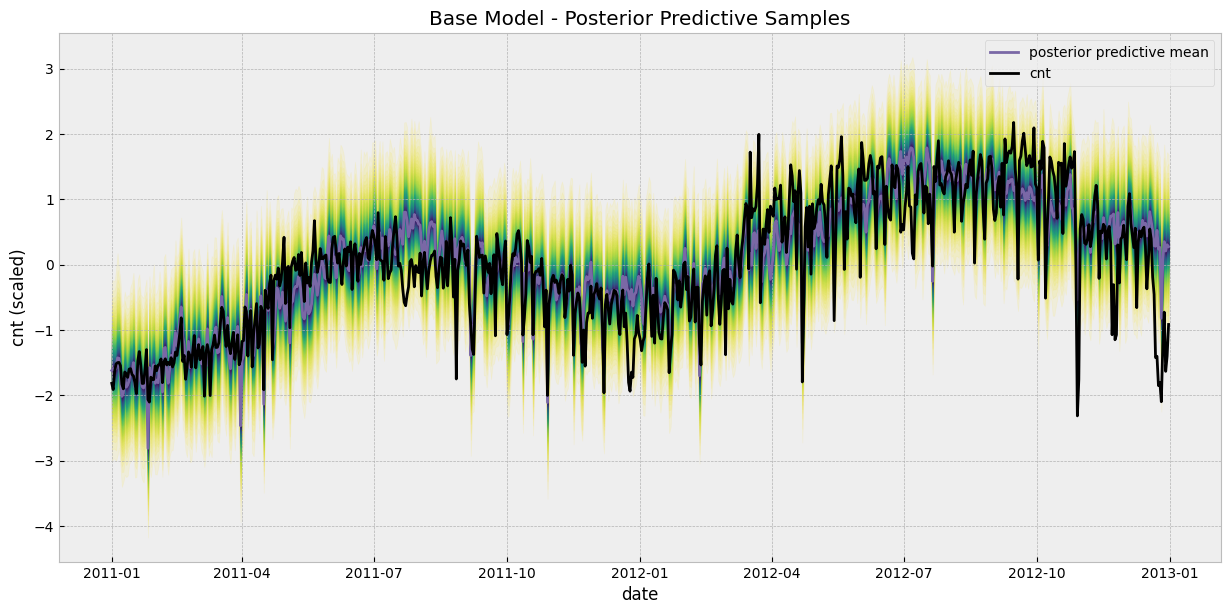

In [28]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood = posterior_predictive.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=cnt_scaled,
    color="black",
    label=target,
    ax=ax,
)

ax.set(
    title="Base Model - Posterior Predictive Samples",
    xlabel="date",
    ylabel=f"{target} (scaled)",
);
